In [ ]:
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00


In [ ]:
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from pprint import pprint

In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
import pathlib
import tensorflow_hub as hub

In [ ]:
import watermark
%load_ext watermark

# Running GPU on Colab

In [ ]:
# confirm that GPU is running
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pwd

/content


In [ ]:
!ls -lF

total 8
drwx------ 5 root root 4096 May  6 01:43 drive/
drwxr-xr-x 1 root root 4096 May  3 13:31 sample_data/


In [ ]:
PROJECT_NAME = "project_food_dl"

In [ ]:
!mkdir -p {PROJECT_NAME}

In [ ]:
!ls -lF

total 12
drwx------ 5 root root 4096 May  6 01:43 drive/
drwxr-xr-x 2 root root 4096 May  6 01:43 project_food_dl/
drwxr-xr-x 1 root root 4096 May  3 13:31 sample_data/


In [ ]:
!ls -lF {PROJECT_NAME}

total 0


In [ ]:
!rm -rf {PROJECT_NAME}/artifacts

In [ ]:
!rm artifacts.zip

rm: cannot remove 'artifacts.zip': No such file or directory


In [ ]:
!rm -rf {PROJECT_NAME}/data

In [ ]:
# create a sub-directory for data
!mkdir -p {PROJECT_NAME}/data

In [ ]:
!mkdir -p {PROJECT_NAME}/artifacts

In [ ]:
!ls {PROJECT_NAME} -lF

total 8
drwxr-xr-x 2 root root 4096 May  6 01:43 artifacts/
drwxr-xr-x 2 root root 4096 May  6 01:43 data/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Get Data

In [ ]:
!cp -r "/content/drive/MyDrive/images" "/content/project_food_dl/data"

In [ ]:
DATA_DIR = str(PROJECT_NAME)+"/data/images"
DATA_DIR = pathlib.Path(DATA_DIR)

In [ ]:
DATA_DIR

PosixPath('project_food_dl/data/images')

# Look at dataset

In [ ]:
# look at folder names
!ls {DATA_DIR} | head -5

Banh_canh
Banh_chung
Banh_cuon
Banh_khot
Banh_mi


In [ ]:
# look at first five images in first image folder
!ls {DATA_DIR}/Banh_canh | head -5

100.jpg
101.jpg
102.jpg
103.jpg
104.jpg


In [ ]:
# find out how many total images there are in database
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
image_count

14318

In [ ]:
# find out how many different classes there are
ALL_CLASS_NAMES = sorted(np.array([item.name for item in DATA_DIR.glob('*')]))
print(len(ALL_CLASS_NAMES))

15


In [ ]:
ALL_CLASS_NAMES[:10]

['Banh_canh',
 'Banh_chung',
 'Banh_cuon',
 'Banh_khot',
 'Banh_mi',
 'Banh_trang_nuong',
 'Banh_xeo',
 'Bun',
 'Canh_chua',
 'Chao_long']

# Use Subset of Data

In [ ]:
# Use full dataset (all classes)
subset = len(ALL_CLASS_NAMES)
subset

15

In [ ]:
# use subset of classes
# NOTE: if subset=11, we are using the full dataset
start = 0
subset = 16
subset = 16

In [ ]:
USE_CLASS_NAMES = ALL_CLASS_NAMES[start:start+subset]
print(len(USE_CLASS_NAMES))
print("first few classes: ")
pprint(USE_CLASS_NAMES[:7])

15
first few classes: 
['Banh_canh',
 'Banh_chung',
 'Banh_cuon',
 'Banh_khot',
 'Banh_mi',
 'Banh_trang_nuong',
 'Banh_xeo']


In [ ]:
# let's examine one class
class1 = USE_CLASS_NAMES[0]
class1

'Banh_canh'

# Save classes as classes.json

In [ ]:
with open(f"{PROJECT_NAME}/artifacts/classes.txt",'w') as f:
  f.write('\n'.join(USE_CLASS_NAMES))

with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
  json.dump(USE_CLASS_NAMES, f)

# Look at Images

Image Size (w, h):  600 , 400


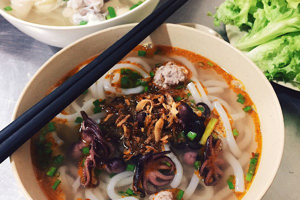

Image Size (w, h):  1200 , 630


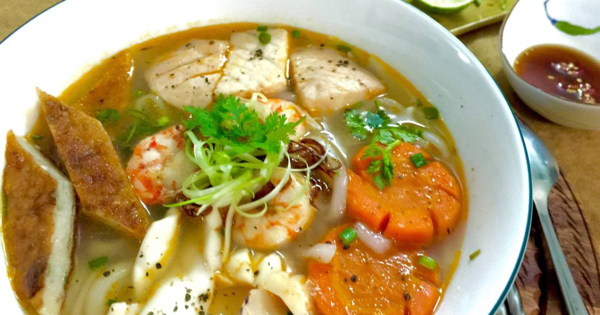

In [ ]:
images = list(DATA_DIR.glob(f'{class1}/*'))

for image_path in images[:2]:
    # resize image
    im = Image.open(str(image_path))
    w, h = im.size
    print('Image Size (w, h): ', w, ",",  h)
    percent_resize = 0.5
    im = im.resize((int(w*percent_resize), int(h*percent_resize)))
    display.display(im)

# Setup for Training Model
The ImageDataGenerator is used to create training and validation splits. It also has several builtin image preprocessing transformations.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
BATCH_SIZE = 48 * len(gpus)
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

print("Number of classes we are training: " ,len(USE_CLASS_NAMES))
print("\nList of classes")  
list(USE_CLASS_NAMES)[:10]

Number of classes we are training:  15

List of classes


['Banh_canh',
 'Banh_chung',
 'Banh_cuon',
 'Banh_khot',
 'Banh_mi',
 'Banh_trang_nuong',
 'Banh_xeo',
 'Bun',
 'Canh_chua',
 'Chao_long']

In [ ]:
def get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input ):

    # use image augmentation
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale = 1./255., 
        validation_split=0.2, 
        rotation_range = 40, width_shift_range = 0.2, 
        height_shift_range = 0.2, shear_range = 0.2, 
        zoom_range = 0.2, horizontal_flip = True ,
        preprocessing_function=preprocessing_function
    )
    
      # create a data generator object with options (location of images, batch size, option to shuffle, etc)
    image_data_gen_train = image_generator.flow_from_directory(
          directory=str(DATA_DIR),
          batch_size=BATCH_SIZE,
          shuffle=True,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          classes = list(USE_CLASS_NAMES) ,
          subset = 'training'
    )
    image_data_gen_validation = image_generator.flow_from_directory(
          directory=str(DATA_DIR),
          batch_size=BATCH_SIZE,
          shuffle=False,
          target_size=(IMG_HEIGHT, IMG_WIDTH),
          classes = list(USE_CLASS_NAMES) ,
          subset = 'validation'
    )
    
    
    return image_data_gen_train,image_data_gen_validation

In [ ]:
image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

Found 11459 images belonging to 15 classes.
Found 2859 images belonging to 15 classes.


# Save list of classes

In [ ]:
image_data_gen_train.num_classes

15

In [ ]:
image_data_gen_train.class_indices.keys()

dict_keys(['Banh_canh', 'Banh_chung', 'Banh_cuon', 'Banh_khot', 'Banh_mi', 'Banh_trang_nuong', 'Banh_xeo', 'Bun', 'Canh_chua', 'Chao_long', 'Com_tam', 'Goi_cuon', 'Hu_tieu', 'Mi_quang', 'Pho'])

In [ ]:
list_of_classes = list(image_data_gen_train.class_indices.keys())

In [ ]:
list_of_classes[:15]

['Banh_canh',
 'Banh_chung',
 'Banh_cuon',
 'Banh_khot',
 'Banh_mi',
 'Banh_trang_nuong',
 'Banh_xeo',
 'Bun',
 'Canh_chua',
 'Chao_long',
 'Com_tam',
 'Goi_cuon',
 'Hu_tieu',
 'Mi_quang',
 'Pho']

In [ ]:
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
    json.dump(list_of_classes, f)

In [ ]:
def load_image(path:str) :
    img = Image.open(path)
    img = np.array(img)/255.0
    return img

In [ ]:
!ls -lh {DATA_DIR}/{class1}/ | head -6

total 145M
-rw------- 1 root root  284K May  6 01:45 100.jpg
-rw------- 1 root root   76K May  6 01:45 101.jpg
-rw------- 1 root root   88K May  6 01:45 102.jpg
-rw------- 1 root root  199K May  6 01:45 103.jpg
-rw------- 1 root root  130K May  6 01:45 104.jpg


# Model Architecture

In [ ]:
# Open a strategy scope and create/restore the model.
strategy = tf.distribute.MirroredStrategy()

## Model: MobileNetV2 (fine-tuned)
https://www.tensorflow.org/guide/keras/transfer_learning

In [ ]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

def get_mobile_net_v2():
    base_layer = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE+(3,) )
    
    model = tf.keras.Sequential([
        #hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,) , name='pretrained')
        base_layer
        , tf.keras.layers.GlobalAveragePooling2D()
        , tf.keras.layers.Dense(1024, activation='relu')

        ,tf.keras.layers.Dense(image_data_gen_train.num_classes , name='classification', activation='softmax')

    ])
    return model

In [ ]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

with strategy.scope():
    clf = get_mobile_net_v2()

In [ ]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 classification (Dense)      (None, 15)                15375     
                                                                 
Total params: 3,585,103
Trainable params: 3,550,991
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
clf.layers[0].trainable = False

In [ ]:
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 classification (Dense)      (None, 15)                15375     
                                                                 
Total params: 3,585,103
Trainable params: 1,327,119
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
clf.compile(
  optimizer=tf.keras.optimizers.Adam(),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,restore_best_weights = False)
]

**epochs = 6**



*   increase batch size until accuracy decreases
*   then rerun from beginning using epoch size where max accuracy was observed




**Model results**

In [ ]:
%%time

image_data_gen_train , image_data_gen_validation = get_image_data_generator (preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf.fit(image_data_gen_train
                  ,validation_data=image_data_gen_validation
                        ,epochs=5
                        ,workers=8
                        ,callbacks=callbacks
                        )

Found 11459 images belonging to 15 classes.
Found 2859 images belonging to 15 classes.
Epoch 1/5
239/239 [==============================] - 395s 2s/step - loss: 1.2403 - accuracy: 0.5979 - val_loss: 1.0155 - val_accuracy: 0.6775 - lr: 0.0010
Epoch 2/5
239/239 [==============================] - 391s 2s/step - loss: 0.9532 - accuracy: 0.6869 - val_loss: 1.0152 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 3/5
239/239 [==============================] - 392s 2s/step - loss: 0.8540 - accuracy: 0.7156 - val_loss: 0.9582 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 4/5
239/239 [==============================] - 393s 2s/step - loss: 0.8125 - accuracy: 0.7265 - val_loss: 0.9504 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 5/5
239/239 [==============================] - 393s 2s/step - loss: 0.7726 - accuracy: 0.7448 - val_loss: 0.8973 - val_accuracy: 0.7111 - lr: 0.0010
CPU times: user 55min 26s, sys: 32.3 s, total: 55min 58s
Wall time: 35min 16s


In [ ]:
# unfreeze first layer
clf.layers[0].trainable = True
clf.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 classification (Dense)      (None, 15)                15375     
                                                                 
Total params: 3,585,103
Trainable params: 3,550,991
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
base_learning_rate=0.001

clf.compile(
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
  #loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss='categorical_crossentropy' ,
  metrics=['accuracy'])

In [ ]:
callbacks = [
    tf.keras.callbacks.CSVLogger(str(str(PROJECT_NAME)+"/artifacts/training_MobileNetV2_ft2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 3,verbose = 1,restore_best_weights = False)
]

In [ ]:
cd /content

/content


In [ ]:
%%time

history = clf.fit(image_data_gen_train
                   ,validation_data=image_data_gen_validation
                        ,epochs=4
                        ,workers=8 
                        ,callbacks=callbacks
                        )

Epoch 1/4
239/239 [==============================] - 427s 2s/step - loss: 0.8689 - accuracy: 0.7120 - val_loss: 1.3714 - val_accuracy: 0.6569 - lr: 1.0000e-04
Epoch 2/4
239/239 [==============================] - 391s 2s/step - loss: 0.5715 - accuracy: 0.8092 - val_loss: 1.2355 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 3/4
185/239 [======================>.......] - ETA: 1:04 - loss: 0.4497 - accuracy: 0.8515

## Save model

In [ ]:
export_path = str(PROJECT_NAME)+"/artifacts/model_MobileNetV2_ft.h5"
export_path
clf.save(export_path, save_format='h5')

In [ ]:
clf_final = clf 

In [ ]:
list_of_classes = list(image_data_gen_train.class_indices.keys())
with open(f"{PROJECT_NAME}/artifacts/classes.json",'w') as f:
    json.dump(list(image_data_gen_train.class_indices.keys()) , f)

# Get Model Size

In [ ]:
! du -h {PROJECT_NAME}/artifacts

28M	project_food_dl/artifacts


In [ ]:
!ls {PROJECT_NAME}/artifacts/ -lah

total 28M
drwxr-xr-x 2 root root 4.0K May  6 03:11 .
drwxr-xr-x 4 root root 4.0K May  6 01:43 ..
-rw-r--r-- 1 root root  182 May  6 03:11 classes.json
-rw-r--r-- 1 root root  136 May  6 01:50 classes.txt
-rw-r--r-- 1 root root  28M May  6 03:11 model_MobileNetV2_ft.h5
-rw-r--r-- 1 root root  434 May  6 03:09 training_MobileNetV2_ft2.log
-rw-r--r-- 1 root root  513 May  6 02:33 training_MobileNetV2.log


# Download Assets

In [ ]:
!zip -r {PROJECT_NAME}/artifacts/artifacts.zip {PROJECT_NAME}/artifacts/

  adding: project_food_dl/artifacts/ (stored 0%)
  adding: project_food_dl/artifacts/classes.txt (deflated 35%)
  adding: project_food_dl/artifacts/training_MobileNetV2.log (deflated 44%)
  adding: project_food_dl/artifacts/classes.json (deflated 45%)
  adding: project_food_dl/artifacts/training_MobileNetV2_ft2.log (deflated 42%)
  adding: project_food_dl/artifacts/model_MobileNetV2_ft.h5 (deflated 12%)


In [ ]:
from google.colab import files
files.download(str(str(PROJECT_NAME)+"/artifacts/artifacts.zip"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model prediction

In [ ]:
cd /content

/content


In [ ]:
!mkdir -p {PROJECT_NAME}/test_image

In [ ]:
img_path = f"{PROJECT_NAME}/test_image/download.jpg" # not in dataset

In [ ]:
img_path

'project_food_dl/test_image/images.jpg'

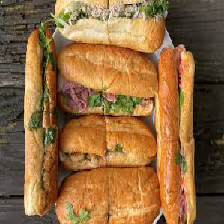

In [ ]:
tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))

In [ ]:
def load_img_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = np.expand_dims(img, axis = 0)
    
    return img

In [ ]:
clf_final.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 classification (Dense)      (None, 15)                15375     
                                                                 
Total params: 3,585,103
Trainable params: 3,550,991
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
def predict_image(img_path,classifier):
    img = load_img_predict(img_path)
    res = classifier.predict(img)

    res = sorted (
        list(zip ( 
            list(image_data_gen_train.class_indices.keys())
            , np.squeeze(res)
         )
        )
     , key=lambda x: x[1]   
     , reverse=True
    )
    
    return res

In [ ]:
predict_image(img_path,clf_final)[:15]

1/1 [==============================] - 0s 79ms/step


[('Bun_dau_mam_tom', 0.8637788),
 ('Com_tam', 0.1230075),
 ('Banh_khot', 0.008121597),
 ('Banh_cuon', 0.0046062837),
 ('Hu_tieu', 0.00044757288),
 ('Chao_long', 2.127846e-05),
 ('Bun_bo_Hue', 6.89992e-06),
 ('Goi_cuon', 5.1406832e-06),
 ('Bun_rieu', 2.315561e-06),
 ('Banh_xeo', 2.2447166e-06),
 ('Mi_quang', 1.8618364e-07),
 ('Banh_canh', 1.0994761e-07),
 ('Pho', 6.4025045e-08),
 ('Banh_mi', 2.0753406e-08),
 ('Canh_chua', 1.0491137e-10)]

# Convert model

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
stat

In [ ]:
cd /content/project_food_dl/artifacts

/content/project_food_dl/artifacts


In [ ]:
!tensorflowjs_converter model_MobileNetV2_ft.h5 model_tfjs \
--input_format keras \
--output_format tfjs_graph_model \
--weight_shard_size_bytes 50000000 \
--quantize_float16

2023-05-06 03:12:40.847784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-06 03:12:46.909051: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
